Objectives: </br>
1. Find the trimers that cause higher LPA distance from the domain (positive).
2. In those positions, what kind of trimers those high-LPA ditance trimers replace?
3. Look at the underexpressed trends.
4. Compare those positions to the high mutability positions from the previous analysis.  

---
# 0. Preperation
1. Loading Models
2. Importing raw data trimers & creating LPA domain
3. Creating trimers information

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scripts import TrimerLPA
import matplotlib.pyplot as plt
from scripts.TrimerAnalyze import medians_info
from scripts.TAhelpers import find_region, assign_region, split_rows, label_2cols

In [2]:
# positions from previus analysis
pa_positions = [ 28,  29,  30,  31,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  99,
       100, 101, 102, 103,  98]

pa_head = [ 98,  86,  41,  83,  38,  81, 102,  75,  89,  44,  46,  37,  40, 51,  79,  94,  39,  48]
pa_tail = [ 64,  59,  58,  90,  92,  65,  87, 101,  62,  74,  95,  66,  57, 69,  55,  45,  68,  85]
 
pa_joined = pa_head +  pa_tail

In [3]:
# raw trimers csv path
raw_trimers_path ="trimers_data\\ab_target-time_point-subject_id-top_seq-trimers_[10.05.25-20;02].csv" 

# importing the raw trimers and selecting only cdr/fw rows
raw_trimers = pd.read_csv("trimers_data\\ab_target-time_point-subject_id-top_seq-trimers_[10.05.25-20;02].csv", index_col=0)
raw_trimers = raw_trimers[raw_trimers.region.isin(['cdr1', 'fw2', 'cdr2', 'fw3'])]

# Adding metadata derived from label column to the raw trimers dataframe
raw_trimers = label_2cols(raw_trimers, {0:"ab_target", 1:"time_point", 2:"subject_id"})#, mapper={0:{"Non-SpikeB":"sn", "Spike+MemB":"sp"}})

# removing trimers with single occurnce
#raw_trimers = raw_trimers[raw_trimers.ncount > 1]

# creating LPA distances object for signatures dataframe
trimer_lpa = TrimerLPA.TrimerLPA(input_data=raw_trimers_path, min_treshold=100)

> The following document havn't met the treshold (100):
                  document  frequency_in_document
19  Spike+MemB.1baseline.7                      2
24     Spike+MemB.2weeks.7                     41
26     Spike+MemB.4weeks.4                     62


In [4]:
# creating df of trimers ordered by positions
trimers_order = raw_trimers.groupby("trimer").agg({"first_aa": lambda X : int(X.value_counts().index[0])}).reset_index().sort_values(by="first_aa")

* Saving the dropped sub-datasets labels for the next step (["Spike+MemB.1baseline.7", "Spike+MemB.2weeks.7", "Spike+MemB.4weeks.4"]).
* Importing the TrimerAnalyze script.
* Using the TrimerAnalysis script in order to analyze certerin trimers presence in positions.

In [6]:
to_save = False

from scripts import TrimerAnalyze 

trimer_init = TrimerAnalyze.TrimerAnalysis(trimer_input=raw_trimers_path) #inititating the class
trimer_divr = trimer_init.diversity_analysis(save_csv=to_save, div_orders= [0, 1, 2, 3]) #creating position analysis
trimer_count = trimer_init.trimer_presence(save_csv=to_save, index_labels = {0:"ab_target", 1:"time_point", 2:"subject_id"}, diversity=[1,2]) #creating trimers analysis

---
# 1. Prelimenary Visualization
1. Creating medians for LPA distances of trimers from the domain
2. Filtring and orgenizing the trimers data by the medians LPA distance 
3. Visualizing the medians distances distribution (by histogram)
4. Visualizing the mean presence in unique position (x-axis) for each trimer in regads to it's mean median (y-axis)

In [7]:
#from scripts.TrimerAnalyze import medians_info as mds
to_save_mds = False

In [8]:
medians = medians_info(raw_trimers = raw_trimers,
                      lpa_sig = trimer_lpa.sig_df,
                      index_unique = {0:["Non-SpikeB", "Spike+MemB"]},
                      index_name="ab_target")

medians_filt = medians.filter_sort(on="Spike+MemB_median",
                                   sort_ascending=False,
                                   filter_how="qnt",
                                   save_csv=to_save_mds)

> 3891 unique trimers in divresity of order 1. Producing histogram.


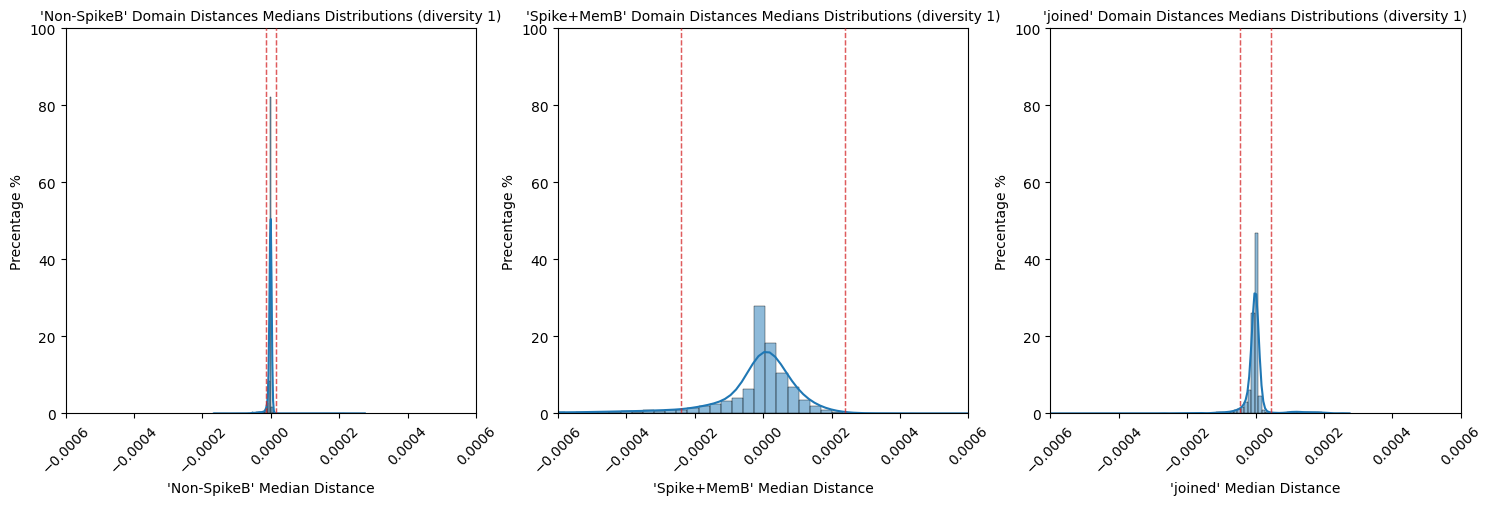

In [9]:
medians.plot_median_hist(trimer_pres=trimer_count,
                         div=1,
                         xy_limit=(-0.0006, 0.0006, 0, 100), 
                         save_fig=to_save_mds)

* Presentation of the trimers median score in relation to its existance across the amino acid positions

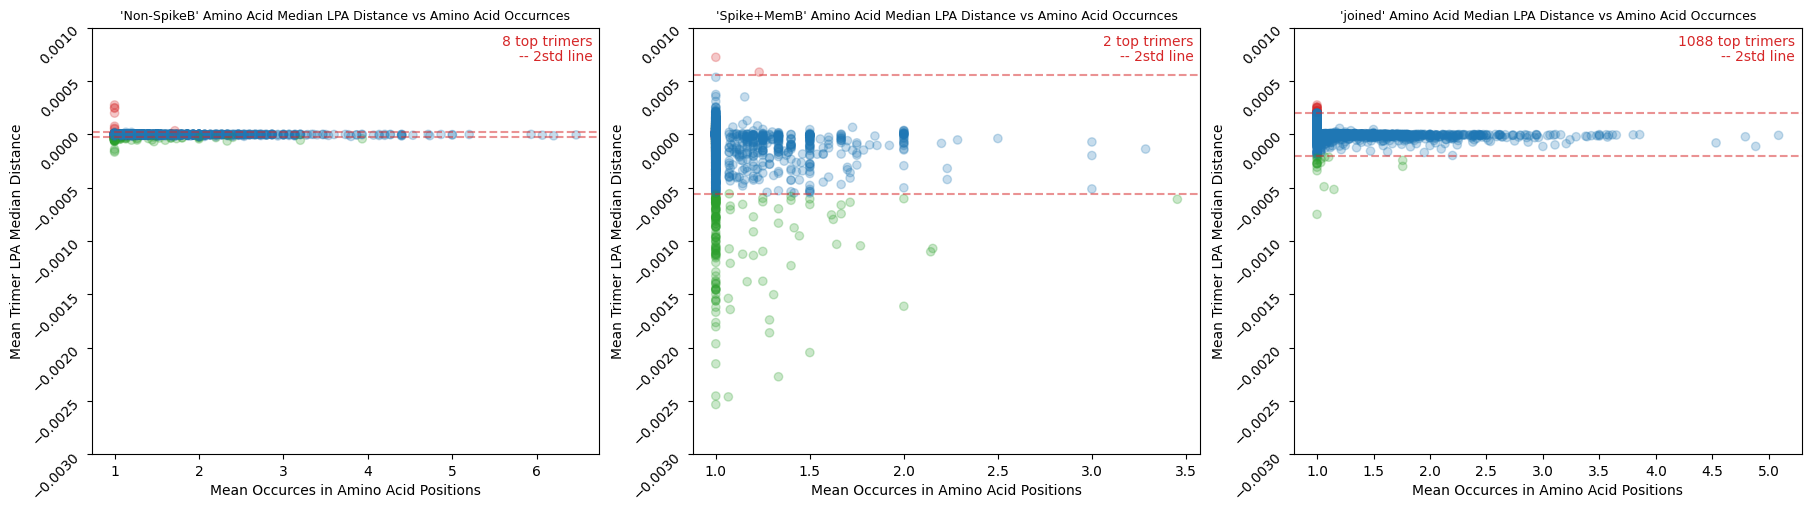

> Non-precense trimers were dropped from the figure, the top trimers count != 25% of the trimers 
> Non-precense trimers still have median distance due to the scoring method.


In [10]:
top_trimers = medians.plot_median_presence(trimer_pres=trimer_count, 
                                           div_pres=1,
                                           stat="2std",
                                           return_data=True,
                                           save_fig=to_save_mds)

Observations:
* showed the presence of trimers
* show the regions distrubitions 
* focus on a region and who patterns

---
# 2. Finding the what trimers cause the LPA distance difference
1. Finding the "top" trimers in the top 0.25 precentile of the median difference.


In [11]:
# diversity of the analysis
div = 1 #diversity order
trimer_count_copy = trimer_count.copy().fillna(0)

# Data of the high medians trimers
filt_high1 = top_trimers['Spike+MemB'].index
filt_high2 = medians_filt[medians_filt["Spike+MemB_median_qnt"] == 1].trimer.unique() #relevent trimers (top median)
relv_high = trimer_count_copy[(trimer_count_copy.trimer.isin(filt_high2)) & (trimer_count_copy[f"div{div}_npos"] != 0)]

# Data of the low median trimers.
filt_low = medians_filt[medians_filt["Spike+MemB_median_qnt"] == 0.25].trimer.unique() #relevent trimers (bottom median)
relv_low = trimer_count_copy[(trimer_count_copy.trimer.isin(filt_low)) & (trimer_count_copy[f"div{div}_npos"] != 0) & (trimer_count_copy[f"div{div}_npos"].notnull())]

# Dataframe of the analysis
pipeline_df = relv_high

---
# 3. Visualizing the top trimers
1. visualizing the frequency of trimers occurnces (in set diversity order) of top/bottom trimers.
2. visualizing the region distubtion of the trimers in pie plot.
3. Presetnting the region distrubtion in stacked-bar format.

* Choosing the top median trimers from the output dataset - intr (abrv for interesting) 
* choocing those trimers from the trimer_count dataframe (trimer in int & diversity != 0)
* visualizing the trimers occurnces frequency via bar plot of the top trimers (marked in red in the previous graph) median score in relation to its existance across the amino acid positions

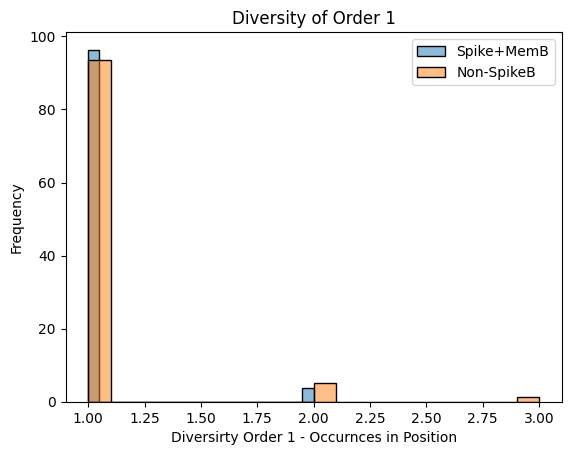

In [12]:
data_div_npos = pipeline_df.groupby(["trimer","ab_target"]).agg({f"div{div}_npos":["nunique"]}).reset_index()

# Frequency that shows the occurnces of the top trimers.
for i in data_div_npos.ab_target.unique():
    temp_data = data_div_npos[data_div_npos.ab_target == i]
    sns.histplot(data=temp_data.iloc[:,2],
                 alpha=0.5,
                 stat="percent", 
                 bins = 20, 
                 label=i)
    plt.xlabel(f"Diversirty Order {div} - Occurnces in Position")
    plt.ylabel("Frequency")
    plt.title(f"Diversity of Order {div}")
    plt.legend()
plt.show()

# Pie charts that show the distrbution of said amino acid across 1)regions 2)subjects for sp and sn clones
# 

* iterating over the rows of relv_trimers (top-median trimers) and extracting the trimer, label, count and unique in diversity of our choocing.
* construct a new dataframe that present the : trimer, label, number of positions in diversity, unique position in diversity (value counts).
* adding region data
* re=arranging the data (groupby) and presenting the top median trimers distrbution across the Heavy variable region

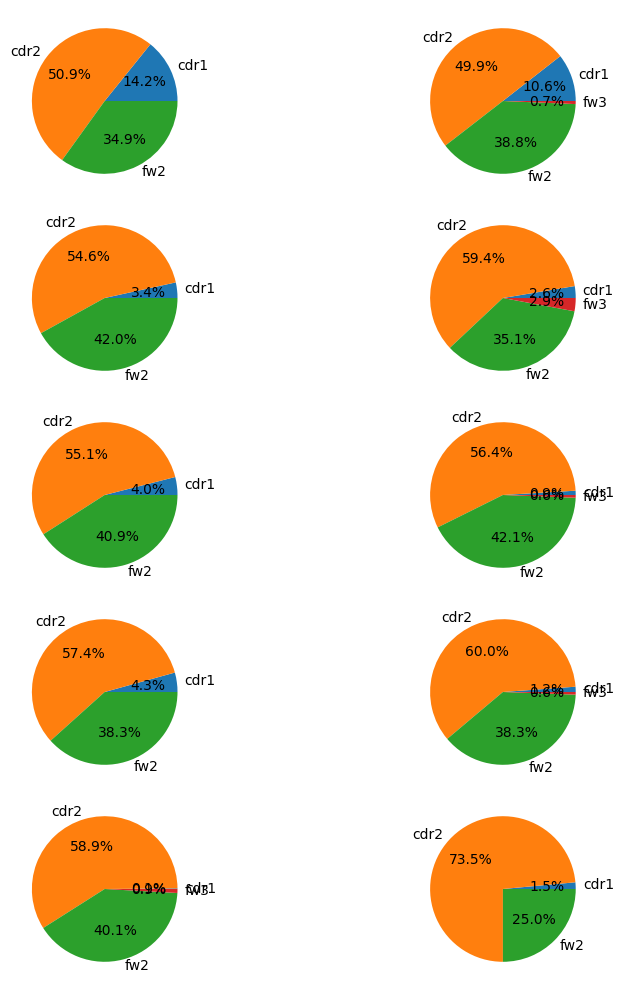

In [13]:
from scripts.TAhelpers import find_region

pos_count_list = []
# positions count
for i in pipeline_df.iterrows():
    i_series = i[1]
    i_trimer = i_series["trimer"]
    i_label = i_series["label"]
    i_div = i_series[f"div{div}_pcount"]
    i_count = i_series[f"div{div}_ncount"]
    
    if isinstance(i_div, (float, int)):
        pos_count_list.append([i_label, i_div, i_div * i_count])

    else:
        for j in i_div:
            pos_count_list.append([i_label, j, i_div[j] * i_count])

pos_count_df = pd.DataFrame(data=pos_count_list, columns=["label","pos","count"])
pos_count_labels = pd.DataFrame(list(pos_count_df.label.str.split(".").values), columns=["ab_target", "time_point", "subject_id"])
pos_count_df = pd.concat([pos_count_df, pos_count_labels], axis=1)
pos_count_df["region"] = pos_count_df.pos.apply(find_region)
count_gb = pos_count_df.groupby(["subject_id","ab_target", "region"])["count"].sum().reset_index()
count_gb = count_gb[count_gb.region != "j"] # j pop-up but with zero count, no idea why. probably bug from the 'find_region' function.

unique_subjects = pos_count_df.subject_id.unique()
unique_target = pos_count_df.ab_target.unique()

fig, axs = plt.subplots(len(unique_subjects), len(unique_target), figsize=(10,10))
for j, nj in zip(unique_subjects, range(0,len(unique_subjects))):
    for i, ni in zip(unique_target, range(0,len(unique_target))):
        i_pie = count_gb[(count_gb["ab_target"] == i) & (count_gb["subject_id"] == j)]
        axs[nj,ni].pie(x=i_pie["count"], 
                        labels=i_pie["region"],
                        autopct='%1.1f%%',
                        normalize=True)

fig.tight_layout()
plt.show()

* Same data from the previous graph shown in stacked bar plot format

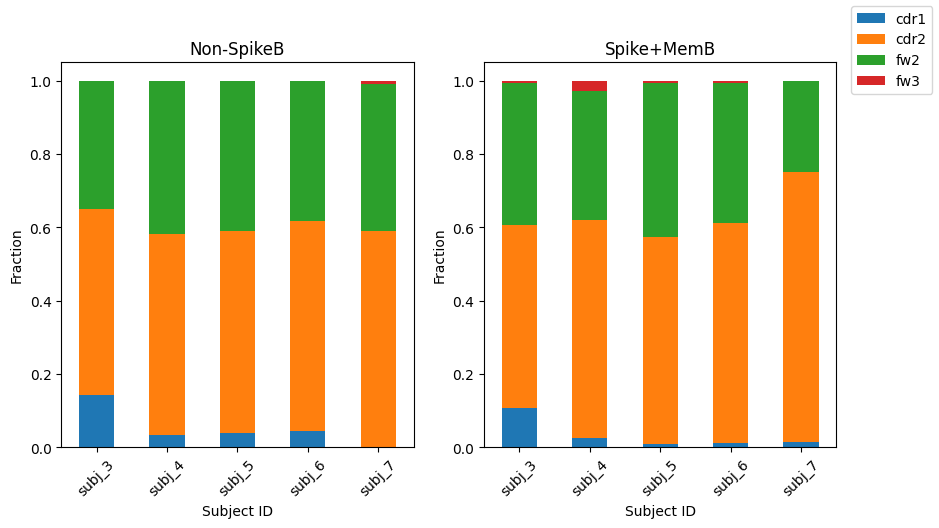

In [14]:
div = 1
pos_count_list = []
# positions count
for i in pipeline_df.iterrows():
    i_series = i[1]
    i_trimer = i_series["trimer"]
    i_label = i_series["label"]
    i_div = i_series[f"div{div}_pcount"]
    i_count = i_series[f"div{div}_ncount"]
    
    if isinstance(i_div, (float, int)):
        pos_count_list.append([i_label, i_div, i_div * i_count])

    else:
        for j in i_div:
            pos_count_list.append([i_label, j, i_div[j] * i_count])

pos_count_df = pd.DataFrame(data=pos_count_list, columns=["label","pos","count"])
pos_count_labels = pd.DataFrame(list(pos_count_df.label.str.split(".").values), columns=["ab_target", "time_point", "subject_id"])
pos_count_df = pd.concat([pos_count_df, pos_count_labels], axis=1)
pos_count_df["region"] = pos_count_df.pos.apply(find_region)
count_gb = pos_count_df.groupby(["subject_id","ab_target", "region"])["count"].sum().reset_index()
count_gb = count_gb[count_gb.region != "j"] # j pop-up but with zero count, no idea why. probably bug from the 'find_region' function.

unique_subjects = pos_count_df.subject_id.unique()
unique_target = pos_count_df.ab_target.unique()


fig, axs = plt.subplots(1, len(unique_target), figsize=(10,5))
for j, axj in zip(unique_target, axs):
    df_j = None
    
    for i in unique_subjects:
        temp_df = count_gb[(count_gb["ab_target"] == j) & (count_gb["subject_id"] == i)].iloc[:,2:].set_index("region")
        temp_df = (temp_df / temp_df.sum()).T
        temp_df.rename(axis=0, mapper={"count":f"subj_{i}"}, inplace=True)
        temp_df.reset_index(drop=False, inplace=True, names="subject")
        temp_df.rename_axis(None, axis=1, inplace=True)

        if df_j is None:
            df_j = temp_df
        else:
            df_j = pd.concat([df_j, temp_df])

        df_j.reset_index(drop=True, inplace=True)

    df_j.plot(x='subject', kind='bar', stacked=True, title='Stacked Bar Graph by dataframe', ax=axj)
    axj.set_title(j)
    axj.tick_params("x", rotation=45)
    axj.set_xlabel("Subject ID")
    axj.set_ylabel("Fraction")
    axj.legend().remove()
    
    ax_h, ax_l = axj.get_legend_handles_labels()

fig.legend(ax_h, ax_l)
plt.show()

---
# 4. Finding the affected amino acids positions

**1. Appraoch I:**
* Finding the high/low trimers (based on their meidan lpa distance value).
* Filtring the trimer count dataset based on those trimers, in defined diversity value (1 in this case).


**2. Approach II:**
* Defining the median-lpa distance filtring method (precentile, 2std).
* Finding the relevent trimers according to out metric.
* Getting the trimers_count dataframe according to out trimers and diversity (diversity =1).
* Mapping the ab_target values for shorter names.
* grouping & reorgenizing the data.
* Finding the affected positions.

In [15]:
### Approach I ###

median_column = "Spike+MemB_median"
medians_stats = medians_filt[median_column].describe()
medians_std = medians_stats["std"]
div = 1

high_2std = medians_filt[medians_filt[median_column] >= 2*medians_std].trimer.unique()
low_2std = medians_filt[medians_filt[median_column] <= -2*medians_std].trimer.unique()

#
def perform_analysis(input_df : pd.DataFrame,
                     trimer_list : list,
                     div : int = 1) -> pd.DataFrame:
    """
    input_df : pd.DataFrame -> 
    trimer_list : array-like -> 
    div : int ->
    """
    cond_trimer = (input_df.trimer.isin(trimer_list))
    cond_notnull = (input_df[f"div{div}_unqpos"].notnull())
    output = split_rows(input_df[cond_trimer & cond_notnull])

    return output

analysis_input = perform_analysis(input_df=trimer_count, trimer_list=high_2std, div=1)

In [16]:
### Approach II ###


# analysis parameters
median_source = "Spike+MemB_median"
div = 1

# Creating median filter for quarltile (qnt4) and every 10% sagment (qnt10).
qrt10 = medians_filt[median_source].quantile(np.arange(0.1, 1.1, 0.1))
qrt4 =  medians_filt[median_source].describe()

# Filtring the data by the median threshold
qnt_top = medians_filt.loc[(medians_filt[median_source] >= qrt4["75%"]), "trimer"].unique()
qnt_bot = medians_filt.loc[(medians_filt[median_source] <= qrt4["25%"]), "trimer"].unique()
print(len(qnt_top), len(qnt_bot))

metric_source = qnt_bot
save_df = True
file_name = "qnt4_bot_grouped.csv"

# Splitting the multiple positions trimers
tc_filt = split_rows(trimer_count[(trimer_count.trimer.isin(metric_source)) & (trimer_count[f"div{div}_npos"] > 0) & (trimer_count[f"div{div}_npos"].notnull())], div=div)

# renaming the 'ab_target' values to {"Non-SpikeB":"sn", "Spike+MemB":"sp"}
# looking for trimers in each ab_target group
tc_filt.loc[:,"ab_target"] = tc_filt.ab_target.map({"Non-SpikeB":"sn", "Spike+MemB":"sp"})
tc_sp = tc_filt[tc_filt.ab_target == "sp"].trimer.unique()
tc_sn = tc_filt[tc_filt.ab_target == "sp"].trimer.unique()

# Orgenizing the data (group-by)
tc_gb = tc_filt.groupby(["trimer", f"div{div}_unqpos", "ab_target"]).agg({"subject_id":["nunique","unique"],
                                                                          f"div{div}_ncount":["sum"],
                                                                         ###"ab_target":["nunique","unique"], 
                                                                         "time_point":["nunique","unique"]}).reset_index().droplevel(axis=1, level=0)
###tc_gb.columns = ["trimer","pos", "n_subj", "unq_subj", "n_target", "unq_target", "n_tp", "unq_tp"]
tc_gb.columns = ["trimer","pos", "ab_target", "n_subj", "unq_subj", "count","n_tp", "unq_tp"]
tc_gb["region"] = tc_gb.pos.apply(find_region)
###tc_gb.loc[:,"unq_target"] = [i[0] if len(i) == 1 else "both" for i in tc_gb.unq_target.values]
###inter_pos = tc_gb.loc[tc_gb.unq_target.isin(["sp", "both"]), ["trimer","pos"]]

if save_df:
    tc_gb.to_csv("trimers_medians_analysis\\"+file_name)

2231 2210


---
# 5. What's in the domain "top" / "bottom" trimers positions?
1. Getting the unique positions of the "top sp" trimers.
2. Using the "trimer_divr" dataframe to look into those specific position in the domain.
3. Adding both the top_seq and germline to the top trimers analysis dataframe.

In [17]:
# Re-orgenizing the top trimers dataframe
tc_filt["div1_unqpos"] = tc_filt["div1_unqpos"].astype("str")
results_df = tc_filt.sort_values("div1_unqpos", ascending=True).iloc[:,:5].groupby(["label", f"div{div}_unqpos"]).agg({"trimer": ["nunique", "unique"]}).reset_index()
results_df.columns = ["label", "pos", "top_n","top_unq"]

# attaching the entire analysis trimers to this data -> to see the "domain"
topseq_divr = trimer_divr[trimer_divr["pos"].isin(results_df.pos.unique())]
topseq_divr = topseq_divr[["label", "pos", f"div{div}" ,f"div{div}_unq"]]
topseq_divr.columns = ["label", "pos", f"topseq_n", f"topseq_unq"]
merged_df = pd.merge(left=results_df, right=topseq_divr, how="left", left_on=["label", "pos"], right_on=["label","pos"])

# adding the germline information
# importing the germline raw trimers
path_germline = "trimers_data\\ab_target-time_point-subject_id-germline-trimers_[15.05.25-14;23].csv"
raw_germline = pd.read_csv(path_germline, index_col=0)
raw_germline = raw_germline[raw_germline.first_aa.isin(topseq_divr.pos.unique())]

# creating diversity trimer analysis
germ_init = TrimerAnalyze.TrimerAnalysis(trimer_input=raw_germline) #inititating the class
germ_divr = germ_init.diversity_analysis(save_csv=False, div_orders= [0, 1]) #creating position analysis
germ_divr = germ_divr[["label", "pos", f"div{div}" ,f"div{div}_unq"]]
germ_divr.columns = ["label", "pos", f"germ_n", f"germ_unq"]

# joining the germline divr data to the results dataframe
merged_df = pd.merge(left=merged_df, right=germ_divr, how="left", left_on=["label", "pos"], right_on=["label","pos"])

# sepereting the metadata label into informative columns
# filling null values with np.nan
# mapping the ab_target values
index_metric = ["ab_target", "time_point", "subject_id"]
merged_df = label_2cols(merged_df, index_labels={0:index_metric[0], 1:index_metric[1], 2:index_metric[2]})
merged_df.fillna(np.nan, inplace=True)
merged_df["ab_target"] = merged_df.ab_target.map({"Non-SpikeB":"sn", "Spike+MemB":"sp"})

# top found in germline
germ_list = []
for i in merged_df.iterrows():
    top = i[1]["top_unq"]
    germ = i[1]["germ_unq"]
  
    if isinstance(germ, float):
        germ_val = np.nan
    else:
        germ_val = len(np.intersect1d(top,germ)) 

    germ_list.append(germ_val)

merged_df["top_in_germ"] = germ_list
merged_df["pos"] = merged_df.pos.astype("int")

medians_analysis_results = merged_df.loc[(merged_df.top_in_germ == 0) & (merged_df.ab_target == "sp"),:].sort_values("pos", ascending=True)

save_results = False
file_name = "high"
if save_results:
    path = f"trimers_medians\\{file_name}_trimers_analysis.csv"
    medians_analysis_results.to_csv(path)


C:\Users\Daniel\AppData\Local\Temp\ipykernel_12284\1451209846.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna(np.nan, inplace=True)


---
# 6. Importing the reults 

In [18]:
high_result = pd.read_csv("trimers_medians\\high_trimers_analysis.csv", index_col=0)
low_result = pd.read_csv("trimers_medians\\low_trimers_analysis.csv", index_col=0)

previous_positions = [104, 98, 41, 43, 86, 83, 38, 81, 102, 89, 44, 75, 46, 94, 37, 51, 79, 40]

inter1d_high = np.intersect1d(high_result.pos.unique(), previous_positions)
inter1d_low = np.intersect1d(low_result.pos.unique(), previous_positions)

In [19]:
print(inter1d_high)
print(inter1d_low)

[ 37  38  41  43  46  86  89 104]
[ 37  40  44  51  94  98 102 104]


I found all the overexpressed trimers -
* which are mutatnts, how many are mutatnts 
* (not in germline, maybe in germline -> but turned into same germline trimers)
	
sp has more variablity, in those trimers -> look at the statistics of the top trimers </br>
how many trimers are overexprres and found in all individuals -> sp/sn/both </br>

- visualize region distrbution of sp/sn.
- verify the gc_gb table to make sure its correct.
- look at both and see whats happning in the sp/sn.


---

**Verifing the 'tc_gb' dataframe**
1. defining the filtring parermeters, i used the top/bottom 25% precent of vlaues (of the median lpa-distance pre trimer from 'median_filt' dataframe).
2. With that filtring metric i choose the unique trimers from the 'medians_filt' dataframe.
3. i created the 'tc_filt' dataframe, cotaining the trimers information using the top medians lpa trimers.
4. i grouped the data by trimer>position>ab_target and got the unique subjects and timepoints per sub-dataset.
5. added region information


**Visualizing the regions distrubtion**

<bound method Figure.tight_layout of <Figure size 1000x500 with 2 Axes>>

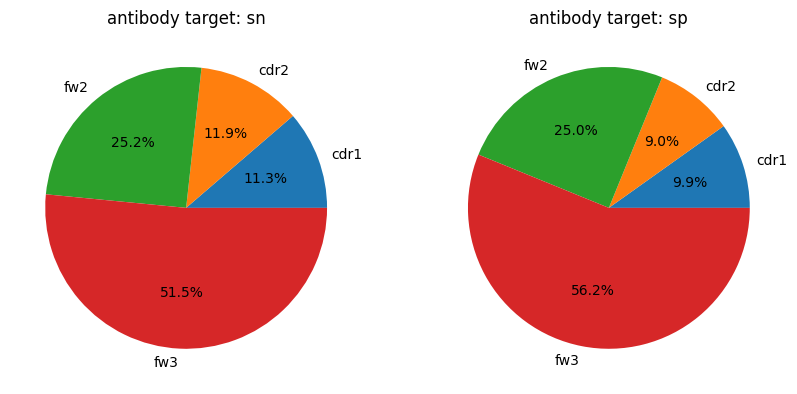

In [20]:
unique_vals = tc_gb.ab_target.unique()
fig, axs = plt.subplots(nrows =1, ncols=len(unique_vals), figsize=(10,5))

for i,ax in zip(unique_vals, axs):
    target_tempdf = tc_gb[tc_gb.ab_target == i]
    pie_df = target_tempdf.groupby("region")["count"].sum().to_frame().reset_index()
    pie_title = f"antibody target: {i}"

    ax.pie(x=pie_df["count"], 
           labels=pie_df["region"],
           autopct='%1.1f%%',
           normalize=True)
    ax.set_title(pie_title)

fig.tight_layout    

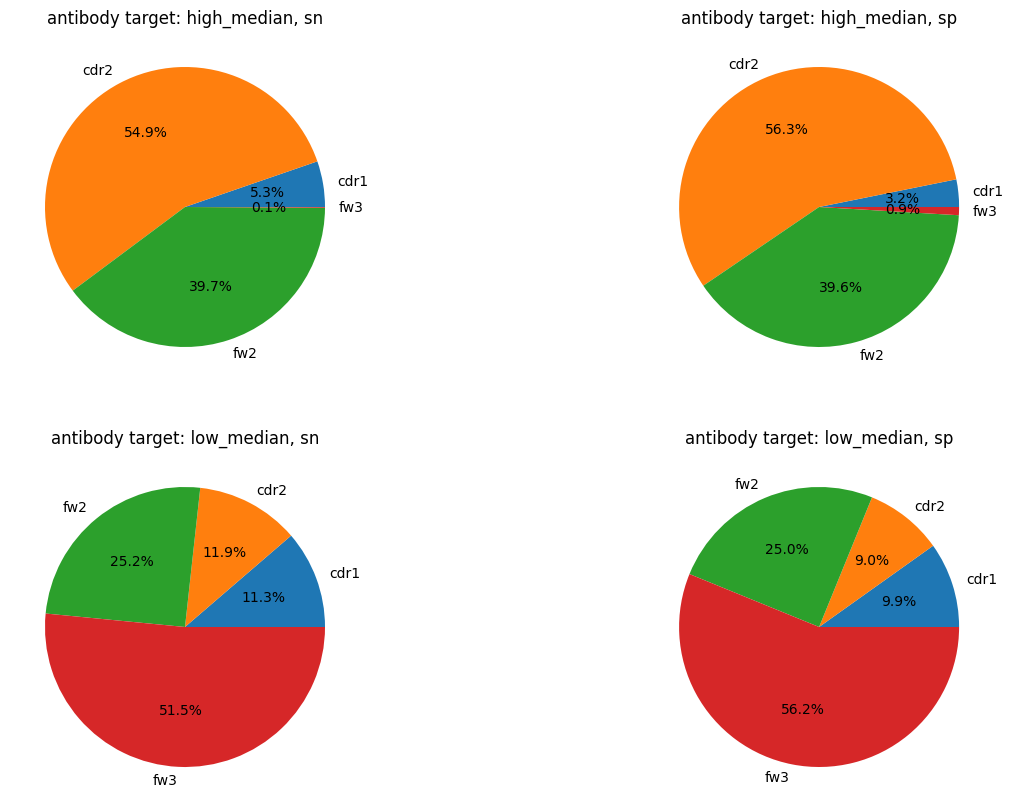

In [21]:
top_grouped = pd.read_csv("trimers_medians_analysis\\qnt4_top_grouped.csv")
bot_grouped = pd.read_csv("trimers_medians_analysis\\qnt4_bot_grouped.csv")

unique_vals = tc_gb.ab_target.unique()
dataframes = [(top_grouped, "high_median"), (bot_grouped, "low_median")]
cond_list = [(i,j) for i in dataframes for j in unique_vals]

fig, axs = plt.subplots(nrows = len(dataframes), ncols=len(unique_vals), figsize=(15,10))
axs_loc = [[i,j] for i in range(0,2) for j in range (0,2)]

for i,j in zip(cond_list, axs_loc):
        i_df = i[0][0]
        i_label = i[0][1]
        i_target = i[1]

        target_tempdf = i_df[i_df.ab_target == i_target]
        pie_df = target_tempdf.groupby("region")["count"].sum().to_frame().reset_index()
        pie_title = f"antibody target: {i_label}, {i_target}"

        axs[j[0], j[1]].pie(x=pie_df["count"], 
               labels=pie_df["region"],
               autopct='%1.1f%%',
               normalize=True)
        axs[j[0], j[1]].set_title(pie_title)

* Look at positions instead of  regions -> positiond.
* divide to subjects.
* add rank column
* redo the table for top-median spike negative ranking
* look at threshold reduction
* look at positions 74,75 whats chaning between sp and sn -> trimer that always in 74,75 if the trimer change and by what/how much.

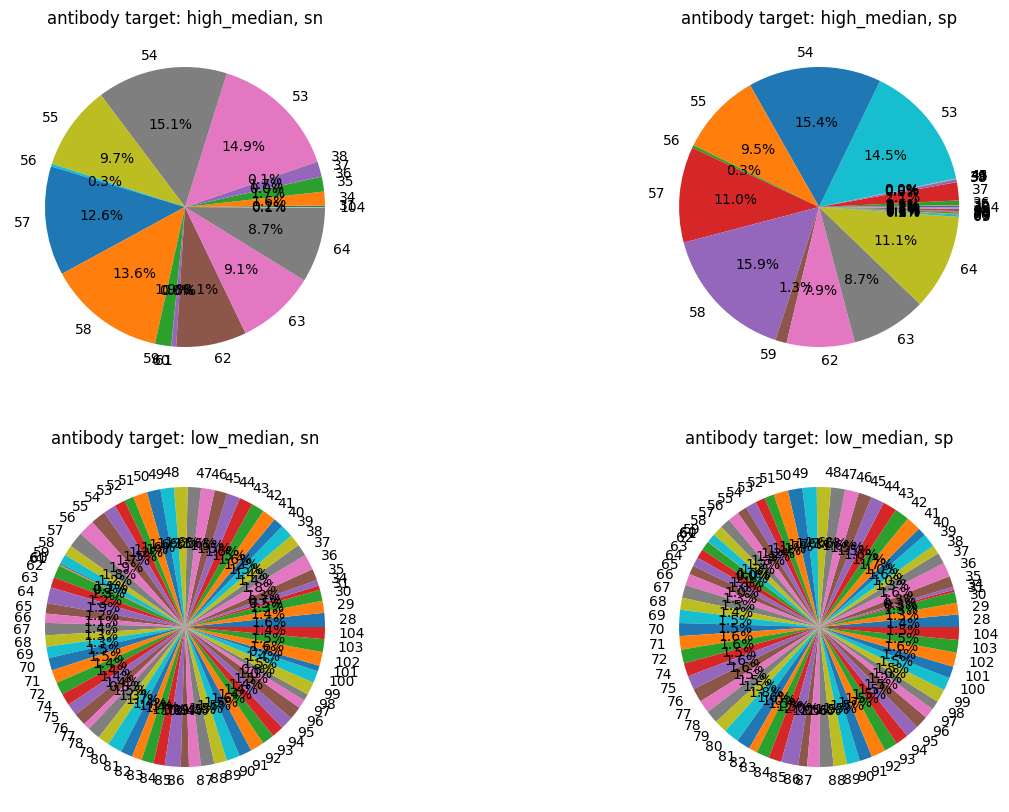

In [22]:
top_grouped = pd.read_csv("trimers_medians_analysis\\qnt4_top_grouped.csv")
bot_grouped = pd.read_csv("trimers_medians_analysis\\qnt4_bot_grouped.csv")

unique_vals = tc_gb.ab_target.unique()
dataframes = [(top_grouped, "high_median"), (bot_grouped, "low_median")]
cond_list = [(i,j) for i in dataframes for j in unique_vals]

fig, axs = plt.subplots(nrows = len(dataframes), ncols=len(unique_vals), figsize=(15,10))
axs_loc = [[i,j] for i in range(0,2) for j in range (0,2)]

for i,j in zip(cond_list, axs_loc):
        i_df = i[0][0]
        i_label = i[0][1]
        i_target = i[1]

        target_tempdf = i_df[i_df.ab_target == i_target]
        pie_df = target_tempdf.groupby("pos")["count"].sum().to_frame().reset_index()
        pie_title = f"antibody target: {i_label}, {i_target}"

        axs[j[0], j[1]].pie(x=pie_df["count"], 
               labels=pie_df["pos"],
               autopct='%1.1f%%',
               normalize=True)
        axs[j[0], j[1]].set_title(pie_title)

**look at both and see whats happning in the sp/sn.**

----

In [23]:
def heatmap_trimers(trimers_input : pd.DataFrame,
                    remove_v1 : bool = False,
                    remove_v0 : bool = True,
                    fig_height : int = 10,
                    div : int = 1,
                    show_fig : bool = True):
    """
    Takes a trimers informative dataframe and visualizing trimers occurnces across different subjects
    as heatmap plot.

    trimers_input : pd.DataFrame -> takes dataframe of trimers with columns of '['subject_id', 'trimer', 'div1_unqpos', 'div1_ncount']'.
    remove_v1 : bool -> replace cells with values smaller than 1 with zeros.
    remove_v0 : bool -> removes rows with the sum of 0.
    fig_height : int -> height of the plot.
    div : int -> order of diversity in analysis.
    show_fig : bool -> show the pyplot figure output.
    """
    
    heatmap_trimers = pd.DataFrame(index = trimers_input.trimer.unique(),
                                   columns= [str(i) for i in range(28,105)],
                                   data=0)

    for sid in trimers_input.subject_id.unique():
        temp_df = trimers_input[trimers_input.subject_id == sid]

        for i in temp_df.iterrows():
            i_trimer, i_pos, i_count = i[1]["trimer"], str(i[1][f"div{div}_unqpos"]), int(i[1][f"div{div}_ncount"])

            if i_trimer in temp_df.trimer.values: 
                heatmap_trimers.loc[i_trimer, i_pos] += 1

    # Removing <1 points
    if remove_v1:
        mask_bool = (heatmap_trimers != 1) 
        heatmap_trimers = heatmap_trimers[mask_bool].fillna(0).astype("int")


    # Removing rows with sum of 0 from plot
    if remove_v0:
        nonzero_rows = (heatmap_trimers.sum(axis=1) != 0)
        heatmap_trimers = heatmap_trimers[nonzero_rows.values]

    heatmap_array, heatmap_cols, heatmap_index = heatmap_trimers.to_numpy(), heatmap_trimers.columns, heatmap_trimers.index

    fig, ax = plt.subplots(1,1, figsize=(16,fig_height))
    sns.heatmap(heatmap_array, ax=ax, cbar_kws={'label': 'Occurrences in Unique Subjects'})
    ax.set_xticks(labels=heatmap_cols, ticks=range(0,77))
    ax.set_xticklabels(labels=heatmap_cols, rotation=90)
    ax.set_yticks(labels=heatmap_index, ticks=range(0,len(heatmap_index)), rotation=0)


    ax.set_xlabel("Unique Trimer")
    ax.set_ylabel("Amino Acid Position")

    range_cdr = list(range(27,39)) + list(range(56,66)) #CDR1, CDR2
    for xtick, xcolor in zip(ax.get_xticklabels(), ["tab:red" if i in range_cdr else "black" for i in heatmap_cols.astype("int")]):
        xtick.set_color(xcolor)

    if show_fig == False:
        plt.close()

    return heatmap_trimers

In [38]:
len(trimer_count[trimer_count["div1_npos"] >= 1].trimer.unique())

3891

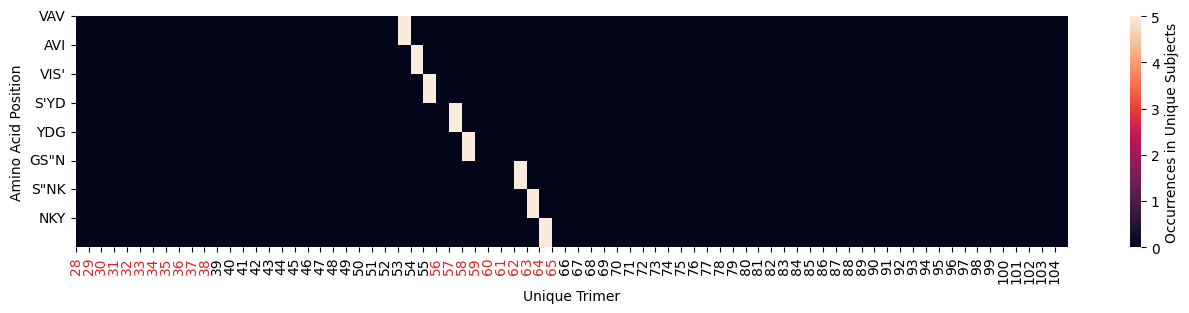

In [24]:
ab_targets = ["Spike+MemB", "Non-SpikeB"]

div = 1
rtimer_count_cp = trimer_count.fillna(0)
rtimer_count_cp = split_rows(rtimer_count_cp[(rtimer_count_cp[f"div1_npos"] != 0) & 
                                             (rtimer_count_cp.trimer.isin(filt_high2)) & 
                                             (rtimer_count_cp.ab_target==ab_targets[0])], div=1)

cp_grouped = rtimer_count_cp.groupby(["subject_id","trimer", f"div{div}_unqpos"]).agg({f"div{div}_ncount":"sum"}).reset_index()
cp_grouped["div1_unqpos"] = cp_grouped["div1_unqpos"].astype("int")
cp_grouped.sort_values("div1_unqpos", inplace=True)

heatmap_sp_sp = heatmap_trimers(cp_grouped,remove_v0=True, remove_v1=True, fig_height=3, show_fig=True)

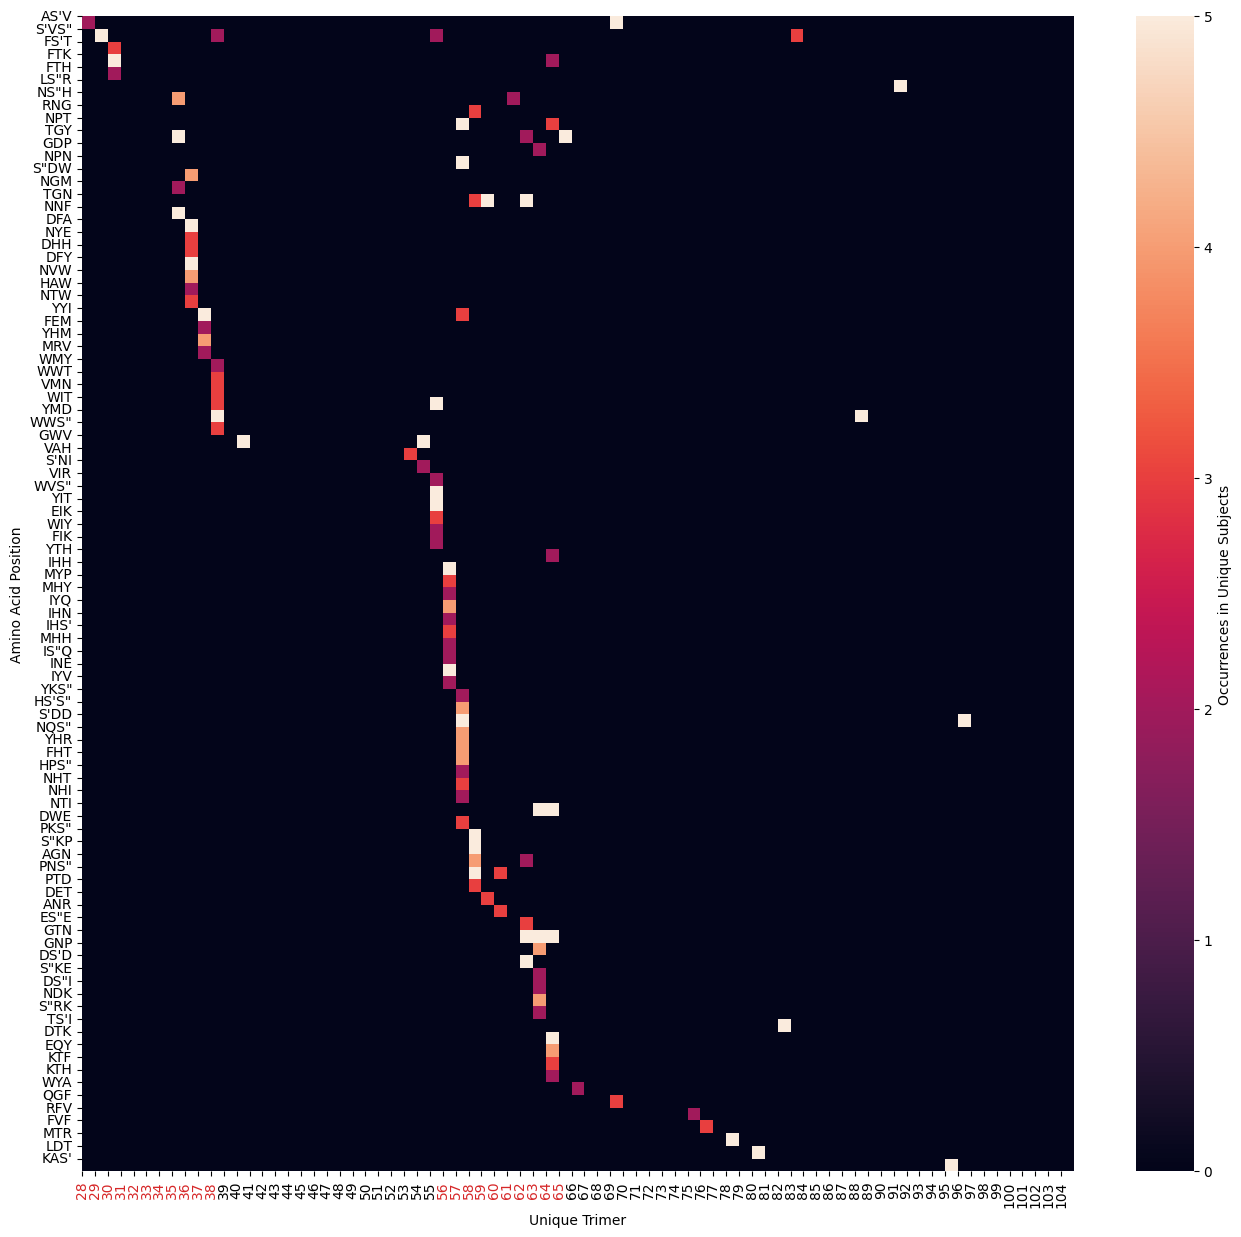

In [25]:
# Sorting the medians_filt dataframe by the SN median values
medians_filt_SN = medians.filter_sort(on="Non-SpikeB_median",
                                      sort_ascending=False,
                                      filter_how="qnt",
                                      save_csv=False)

# Getting a list of the top precentile trimers (unique)
filt_high3 = medians_filt_SN[medians_filt_SN["Non-SpikeB_median_qnt"] == 1].trimer.unique() #relevent trimers (top median - by SN)

# List of ab_target types
ab_targets = ["Spike+MemB", "Non-SpikeB"]

# Getting relevent SN top trimers values
div = 1
rtimer_count_SN = trimer_count.fillna(0)
rtimer_count_SN = split_rows(rtimer_count_SN[(rtimer_count_SN[f"div1_npos"] != 0) & 
                                             (rtimer_count_SN.trimer.isin(filt_high3)) & 
                                             (rtimer_count_SN.ab_target==ab_targets[1])], div=1)
SN_grouped = rtimer_count_SN.groupby(["subject_id","trimer", f"div{div}_unqpos"]).agg({f"div{div}_ncount":"sum"}).reset_index()
SN_grouped["div1_unqpos"] = SN_grouped["div1_unqpos"].astype("int")
SN_grouped.sort_values("div1_unqpos", inplace=True)

heatmap_sn_sp = heatmap_trimers(SN_grouped, remove_v0=True, remove_v1=True, fig_height=15)

----

In [26]:
def abt_bars(input_df : pd.DataFrame,
             on_col : str = "ab_target",
             div : int = 1):
    """
    input_df = input dataframe, after the function 'split_rows' processed it.
    on_col = by what column to seperate the data, is 'ab_target' by defualt.
    div = diversity order of interst, defualt is 1 (deteminted by the prevoius dataframe construction).
    """
    
    # Grouping the data
    stacked_bar = input_df.groupby(["subject_id", "ab_target", "region"]).agg({f"div{div}_ncount":"sum"}).reset_index()

    # Creting template dataframe for the visualization process
    temp_list = []
    template_df = pd.DataFrame(columns=["subject", "cdr1", "cdr2", "fw2", "fw3"])

    # Processing the data by 'subject_id' - for the different bars
    for sid in stacked_bar.subject_id.unique():
        for tid in stacked_bar.ab_target.unique():
            subject = f"subject_{sid}"
            temp_df = stacked_bar[(stacked_bar.subject_id == sid) &(stacked_bar.ab_target == tid)].copy()
            temp_df.loc[:,"fraction"] = (temp_df.div1_ncount / temp_df.div1_ncount.sum()).values

            filled_temp = temp_df[["region", "fraction"]].set_index("region").T
            filled_temp.reset_index(drop=True, inplace=True)
            filled_temp = filled_temp.rename_axis(None, axis=1)
            filled_temp.insert(0, "subject", [sid])
            filled_temp.insert(0, "ab_target", [tid])
            
            temp_list.append(filled_temp)
    
    # Unifing the datasets 
    stacked_df = pd.concat(temp_list).fillna(0)
    unique_target = stacked_df.ab_target.unique()

    # Creating stacked-bar plot, each subplot represents the 'on_col' and each bar dereived from different subject ('subject_id')
    fig, axs = plt.subplots(1, len(unique_target), figsize=(10,5))

    for j, ax_j in zip(unique_target, axs):
        df_j = stacked_df[stacked_df.ab_target == j]
        
        df_j.plot(x='subject', kind='bar', stacked=True, title='Stacked Bar Graph by dataframe', ax=ax_j)
        ax_j.set_title(j)
        ax_j.tick_params("x", rotation=0)
        ax_j.set_xlabel("Subject")
        ax_j.set_ylabel("Region Fraction")
        ax_j.legend().remove()
        
        ax_h, ax_l = ax_j.get_legend_handles_labels()

    fig.legend(ax_h, ax_l)
    plt.show()

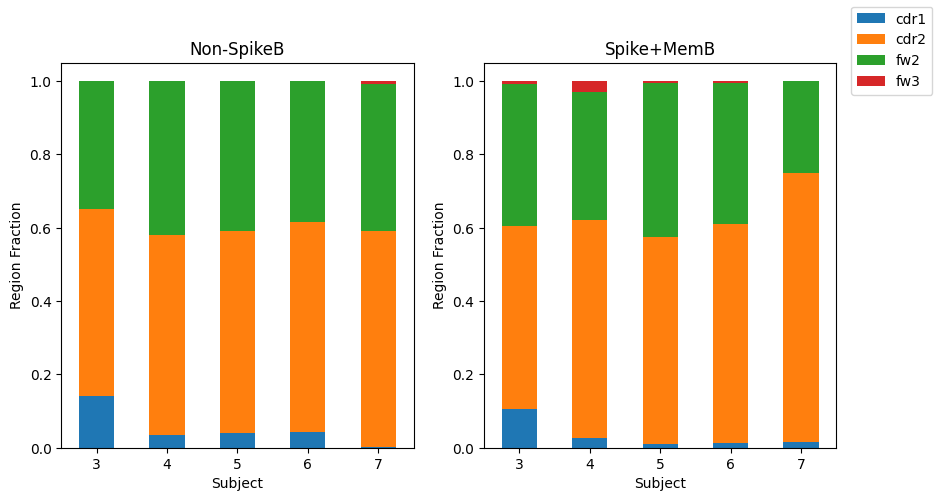

In [27]:
rtimer_count_cp = trimer_count.fillna(0)
rtimer_count_cp = split_rows(rtimer_count_cp[(rtimer_count_cp[f"div1_npos"] != 0) & (rtimer_count_cp.trimer.isin(filt_high2))], div=1)

abt_bars(input_df=rtimer_count_cp)

---

In [28]:
# pre 60% filtring
#pa_head = [104, 98, 41, 43, 86, 83, 38, 81, 102, 89, 44, 75, 46, 94, 37, 51, 79, 40]
#pa_tail = [64, 59, 58, 92, 90, 87, 65, 62, 66, 95, 57, 69, 35, 45, 68, 85, 55, 54]

In [29]:
# > more unique to SP trimers in sn
tcount = split_rows(trimer_count.dropna(axis=0, thresh=11), div=div)

# unique trimers from SP that dosent exists in SN, head trimers
tcount_head = tcount[tcount[f"div{div}_unqpos"].isin([str(i) for i in pa_head])] # getting the 'trimer_count' of only the head positions
unique_headsn = tcount_head.loc[tcount_head.ab_target == "Non-SpikeB", "trimer"].unique() # getting the unique trimers found in SN & in head positions
unique_headsp = tcount_head.loc[tcount_head.ab_target == "Spike+MemB", "trimer"].unique() # getting the unique trimers found in SP & in head positions
unique_topsp = np.setdiff1d(unique_headsp, unique_headsn) # getting the trimers that are found in SP and not in SN in head position (div = 1)

# unique trimers from SP that dosent exists in SN, tail trimers
tcount_tail = tcount[tcount[f"div{div}_unqpos"].isin([str(i) for i in pa_tail])] # getting the 'trimer_count' of only the tail positions
unique_tailsn = tcount_tail.loc[tcount_tail.ab_target == "Non-SpikeB", "trimer"].unique() # getting the unique trimers found in SN & in tail positions
unique_tailsp = tcount_tail.loc[tcount_tail.ab_target == "Spike+MemB", "trimer"].unique() # getting the unique trimers found in SP & in tail positions
unique_tailsp = np.setdiff1d(unique_tailsp, unique_tailsn) # getting the trimers that are found in SP and not in SN in tail position (div = 1)



In [30]:
# > higher diversity of positions in tail
div_head_avg = trimer_divr[trimer_divr.pos.isin([str(i) for i in pa_head])].groupby(["pos"]).agg({"div1":["mean", "std"]}).reset_index()
div_tail_avg = trimer_divr[trimer_divr.pos.isin([str(i) for i in pa_tail])].groupby(["pos"]).agg({"div1":["mean", "std"]}).reset_index()

In [31]:
ab_targets = ["Spike+MemB", "Non-SpikeB"]

div = 1
rtimer_count_cp = trimer_count.fillna(0)
rtimer_count_cp = split_rows(rtimer_count_cp[(rtimer_count_cp[f"div1_npos"] != 0) & 
                                             (rtimer_count_cp.trimer.isin(filt_high2)) & 
                                             (rtimer_count_cp.ab_target==ab_targets[0])], div=1)

cp_grouped = rtimer_count_cp.groupby(["subject_id","trimer", f"div{div}_unqpos"]).agg({f"div{div}_ncount":"sum"}).reset_index()

In [32]:
# Head trimers that are found only in SP (div=1), by SP medians sorting
matrix_head_sp = heatmap_trimers(cp_grouped, remove_v0=True, remove_v1=False, fig_height=3, show_fig=False)
trimers_nonzero_sphead = matrix_head_sp[matrix_head_sp.sum(axis=1) != 0].index
head_sp_common = np.intersect1d(trimers_nonzero_sphead , unique_topsp)
relv_head_sp = tcount[tcount.trimer.isin(head_sp_common)].sort_values(["div1_unqpos","div1_ncount"])
relv_head_sp = relv_head_sp[relv_head_sp.div1_unqpos.isin([str(i) for i in pa_head])]

# trimers from the 1st precentile that appears only in SP rows in the head amino acid positions from the prevoius analysis (div=1)
frac_head = relv_head_sp.groupby("region").agg({f"div{div}_ncount":"sum"})
frac_head

,div1_ncount
region,
cdr1,47
fw2,6
fw3,17


In [33]:
# Tail trimers that are found only in SP (div=1), by SP medians sorting
matrix_tail_sp = heatmap_trimers(cp_grouped, remove_v0=True, remove_v1=False, fig_height=3, show_fig=False)
trimers_nonzero_sptail = matrix_tail_sp[matrix_tail_sp.sum(axis=1) != 0].index
tail_sp_common = np.intersect1d(trimers_nonzero_sphead , unique_tailsp)
relv_tail_sp = tcount[tcount.trimer.isin(tail_sp_common)].sort_values(["div1_unqpos","div1_ncount"])
relv_tail_sp = relv_tail_sp[relv_tail_sp.div1_unqpos.isin([str(i) for i in pa_tail])]

# trimers from the 1st precentile that appears only in SP rows in the tail amino acid positions from the prevoius analysis (div=1)
frac_tail = relv_tail_sp.groupby("region").agg({f"div{div}_ncount":"sum"}) 
frac_tail 

,div1_ncount
region,
cdr2,75
fw2,10
fw3,12


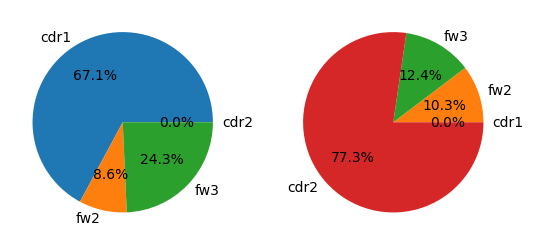

In [34]:
frac_concat = pd.concat([frac_head, frac_tail], axis=1)
frac_concat.columns = ["head_sp", "tail_sp"]
frac_concat.fillna(0, inplace=True)

fig, axs = plt.subplots(1,2)

for i in range(0,2):
    temp_data = frac_concat.iloc[:,i]
    axs[i].pie(x=temp_data,
                  labels=temp_data.index,
                  autopct='%1.1f%%',
                  #normalize=True,
                  #title=frac_concat.columns[i]
                  )